## ロジスティック回帰

- 目的変数が（基本的には）2値の質的データ
- 回帰という名前がついているが、分類を行う

In [1]:
import pandas as pd
import seaborn as sns
iris = sns.load_dataset('iris')

# 2値データへの分類のため、species から setosa を除外
df = iris.query('species!="setosa"')

# speciesを 0, 1 にするためにダミー変数化
df = pd.get_dummies(data=df, drop_first=True)
# 確認のため 0, 50 行目を表示
df.iloc[[0, 50]]

,sepal_length,sepal_width,petal_length,petal_width,species_virginica
50,7.0,3.2,4.7,1.4,0
100,6.3,3.3,6.0,2.5,1


### petal_width を説明変数としてロジスティック回帰モデルを作成

Boundary: 1.6316553684886925


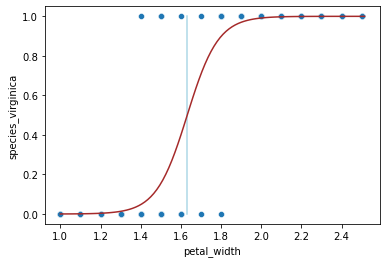

In [2]:
from sklearn.linear_model import LogisticRegression

X = df[['petal_width']]
Y = df.species_virginica

# ロジスティック回帰モデルを作成
# - C: 正則化のパラメータ（sklearnのロジスティック回帰はL2正則化がデフォルト）
#      Cを大きくして正則化の影響が小さくする
model = LogisticRegression(C=10000.0)
model.fit(X, Y)

# 散布図にシグモイド曲線を重ねて表示する
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x, b0, b1):
    return 1/(1 + np.exp(-(b0 + b1 * x)))

# 散布図
sns.scatterplot(x=X.iloc[:,0], y=Y)

# パラメータ
b0 = model.intercept_[0]
b1 = model.coef_[0][0]

# y=0.5となる分割線
_x = -b0 / b1
plt.plot([_x, _x], [0, 1], color='lightblue')
print('Boundary:', _x)

# シグモイド曲線
_max = X.iloc[:,0].max()
_min = X.iloc[:,0].min()
_step = (_max - _min) / 100
_X = np.arange(_min, _max + _step, _step)
plt.plot(_X, sigmoid(_X, b0, b1), color='brown')
plt.show()

<hr>
<img src='slides/6_27.png'>
<hr>

In [3]:
# 教師データについてモデルからの予測値を計算
Y_predict = model.predict(X)
# 混合行列
# - 1行目1列：実際が0、予測が0 (真陰性：TN)
# - 1行目2列：実際が0、予測が1 (偽陽性：FP)
# - 2行目1列：実際が1、予測が0 (偽陰性：FN)
# - 2行目2列：実際が1、予測が1 (真陽性：TP)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(Y, Y_predict)
# 確認
matrix

array([[48,  2],
       [ 4, 46]])

In [4]:
# 正確度、適合度、再現率（感度）、特異度
# - 特異度の関数は sklearn.metrics には無い
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 特異度 = TN / (FP + TN)
specificity = matrix[0, 0] / (matrix[0, 1] + matrix[0, 0])

print('正確度: {:.3f}, 適合度: {:.3f}, 再現率: {:.3f}, 特異度: {:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), specificity))

正確度: 0.940, 適合度: 0.958, 再現率: 0.920, 特異度: 0.960


## 日本語フォントの設定

matplotlib のデフォルトでは英語フォントの設定になっているため、日本語を表示させたい場合には、日本語のフォントを設定する必要がある

In [5]:
# matplotlib: 日本語フォントの設定
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 
                               'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

<hr>
<img src='slides/6_33.png'>
<hr>

Text(0.5, 1.0, 'ROC曲線: AUC=0.980')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Maru Gothic Pro, Yu Gothic, Meirio, Takao, IPAexGothic, IPAPGothic, Noto Sans CJK JP
/home/ryujioda/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryujioda/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32218 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Maru Gothic Pro, Yu Gothic, Meirio, Takao, IPAexGothic, IPAPGothic, Noto Sans CJK JP
/home/ryujioda/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:24

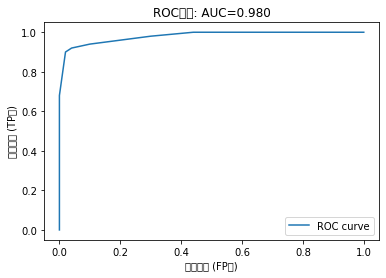

In [6]:
# ROC曲線, AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('偽陽性率 (FP率)')
plt.ylabel('真陽性率 (TP率)')
plt.legend()
plt.title('ROC曲線: AUC={:.3f}'.format(auc(fpr, tpr)))